In [ ]:
#!git clone https://github.com/kelvis24/cell-counting.git

Cloning into 'cell-counting'...
remote: Enumerating objects: 505, done.
remote: Total 505 (delta 0), reused 0 (delta 0), pack-reused 505
Receiving objects: 100% (505/505), 43.76 MiB | 19.03 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [ ]:
!unzip /content/IDCIAv2.zip

Archive:  /content/IDCIAv2.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of /content/IDCIAv2.zip or
        /content/IDCIAv2.zip.zip, and cannot find /content/IDCIAv2.zip.ZIP, period.


In [ ]:

import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from skimage.io import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split




In [ ]:
class IDCIAv2(Dataset):
    def __init__(self, image_files, csv_files, transform=None):
        self.image_files = image_files
        self.csv_files = csv_files
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = self.image_files[idx]
        csv_path = self.csv_files[idx]


        image = imread(image_path)
        # Read the csv file and get the number of cells in the image
        ground_truth = pd.read_csv(csv_path)
        cell_count = ground_truth.shape[0]

        if self.transform:
            image = self.transform(image)

        return image, cell_count

# Data preprocessing and augmentation
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


In [ ]:

# Load image and CSV file paths
image_dir = '/content/IDCIAv2/images'
csv_dir = '/content/IDCIAv2/ground_truth'
image_files = [os.path.join(image_dir, filename) for filename in os.listdir(image_dir)]
csv_files = [os.path.join(csv_dir, filename.replace('.tiff', '.csv')) for filename in os.listdir(image_dir)]

# Split data into train, validation, and test sets
train_files, test_files, train_csv, test_csv = train_test_split(image_files, csv_files, test_size=0.3, random_state=42)
val_files, test_files, val_csv, test_csv = train_test_split(test_files, test_csv, test_size=0.5, random_state=42)

# Create instances of the dataset for training, validation, and testing
train_dataset = IDCIAv2(image_files=train_files, csv_files=train_csv, transform=transform)
val_dataset = IDCIAv2(image_files=val_files, csv_files=val_csv, transform=transform)
test_dataset = IDCIAv2(image_files=test_files, csv_files=test_csv, transform=transform)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Statistics of datasets
train_cell_counts = [sample[1] for sample in train_dataset]
val_cell_counts = [sample[1] for sample in val_dataset]
test_cell_counts = [sample[1] for sample in test_dataset]

# Calculate statistics
num_train_images = len(train_dataset)
num_val_images = len(val_dataset)
num_test_images = len(test_dataset)

mean_train_cells_per_image = np.mean(train_cell_counts)
std_train_cells_per_image = np.std(train_cell_counts)

mean_val_cells_per_image = np.mean(val_cell_counts)
std_val_cells_per_image = np.std(val_cell_counts)

mean_test_cells_per_image = np.mean(test_cell_counts)
std_test_cells_per_image = np.std(test_cell_counts)

stats = {
    'Dataset': ['Training', 'Validation', 'Test'],
    'Number of Images': [num_train_images, num_val_images, num_test_images],
    'Mean Cell Counts': [np.mean(train_cell_counts), np.mean(val_cell_counts), np.mean(test_cell_counts)],
    'Std Deviation Cell Counts': [np.std(train_cell_counts), np.std(val_cell_counts), np.std(test_cell_counts)]

}

# Create a DataFrame
df = pd.DataFrame(stats)

# Display the table
print("Statistics of Datasets:")
print(df)


Statistics of Datasets:
      Dataset  Number of Images  Mean Cell Counts  Std Deviation Cell Counts
0    Training               175        185.148571                 197.393532
1  Validation                37        216.918919                 214.412129
2        Test                38        245.710526                 200.651689


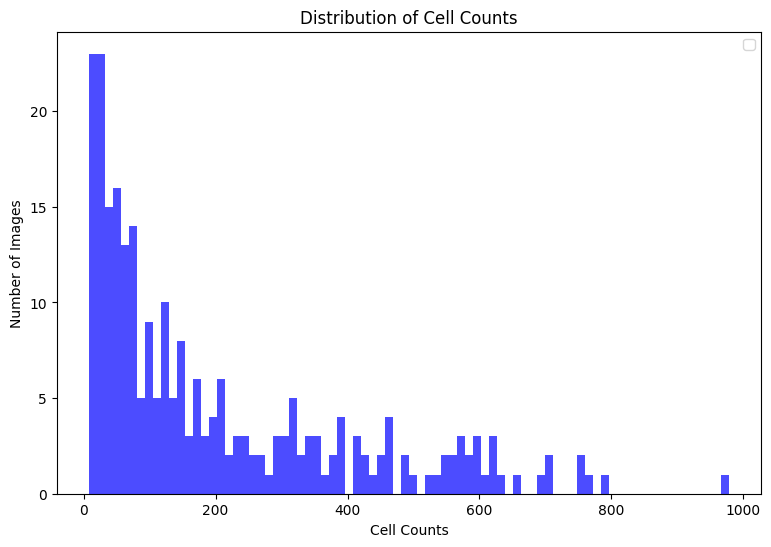

In [ ]:
# Create histograms
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
all_data = train_cell_counts + val_cell_counts + test_cell_counts


plt.hist(all_data, bins=80, density=False, alpha=0.7, color='blue')
#plt.hist(train_cell_counts, bins=60, density=False, alpha=0.7, color='red', label="Training")
#plt.hist(val_cell_counts, bins=60, density=False, alpha=0.7, color='orange', label="Validation")
#plt.hist(test_cell_counts, bins=60, density=False, alpha=0.7, color='green', label="Testing")
plt.title("Distribution of Cell Counts")
plt.xlabel("Cell Counts")
plt.ylabel("Number of Images")
plt.legend()


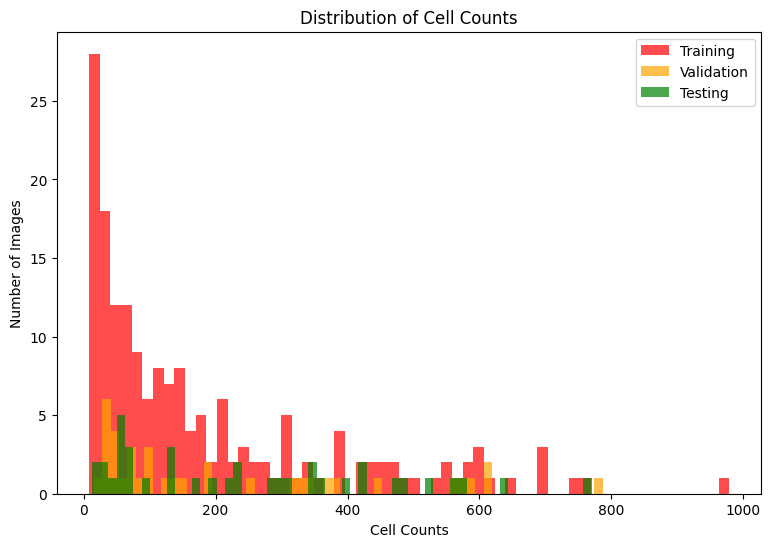

In [ ]:
# Create histograms
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)

plt.hist(train_cell_counts, bins=60, density=False, alpha=0.7, color='red', label="Training")
plt.hist(val_cell_counts, bins=60, density=False, alpha=0.7, color='orange', label="Validation")
plt.hist(test_cell_counts, bins=60, density=False, alpha=0.7, color='green', label="Testing")
plt.title("Distribution of Cell Counts")
plt.xlabel("Cell Counts")
plt.ylabel("Number of Images")
plt.legend()

VGG16 Model

In [ ]:
import torch
import torch.nn as nn
from torchvision import models


class VGG16Regression(nn.Module):
    def __init__(self):
        super(VGG16Regression, self).__init__()
        # Load pre-trained VGG16 model
        self.vgg16 = models.vgg16(pretrained=True).features

        # Freeze the pre-trained layers
        for param in self.vgg16.parameters():
            param.requires_grad = False

        # Custom layers for regression
        self.regressor = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 7 * 7, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        x = self.vgg16(x)
        x = self.regressor(x)
        return x

# Instantiate the model
vgg16 = VGG16Regression()

loss_function = nn.MSELoss()
mae = nn.L1Loss()
optimizer = torch.optim.Adam(vgg16.regressor.parameters(), lr=0.001)


# def norm_mse(y_pred, y_true):
#     return torch.mean((((y_pred - y_true) ** 2)/y_pred))



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 133MB/s]


In [ ]:
from torchsummary import summary
summary(vgg16)



TypeError: ignored

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg16 = vgg16.to(device)

# Lists to store metrics
train_losses = []
train_maes = []
val_losses = []
val_maes = []

# Early stopping parameters
early_stopping_patience = 10
epochs_no_improve = 0
min_val_loss = float('inf')

num_epochs = 500

for epoch in range(num_epochs):
    # Training Phase
    vgg16.train()
    running_loss = 0.0
    running_mae = 0.0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        targets = targets.float().unsqueeze(1)

        optimizer.zero_grad()
        outputs = vgg16(inputs)
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_mae += mae(outputs, targets).item() * inputs.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    train_mae = running_mae / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_maes.append(train_mae)

    # Validation Phase
    vgg16.eval()
    val_running_loss = 0.0
    val_running_mae = 0.0

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            targets = targets.float().unsqueeze(1)

            outputs = vgg16(inputs)
            loss = loss_function(outputs, targets)

            val_running_loss += loss.item() * inputs.size(0)
            val_running_mae += mae(outputs, targets).item() * inputs.size(0)

    val_loss = val_running_loss / len(val_loader.dataset)
    val_mae = val_running_mae / len(val_loader.dataset)
    val_losses.append(val_loss)
    val_maes.append(val_mae)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Loss: {train_loss:.4f} - '
          f'MAE: {train_mae:.4f} - '
          f'Val_Loss: {val_loss:.4f} - '
          f'Val_MAE: {val_mae:.4f}')


    # Early stopping check
    if val_loss < min_val_loss:
        epochs_no_improve = 0
        min_val_loss = val_loss
    else:
        epochs_no_improve += 1
        if epochs_no_improve == early_stopping_patience:
            print(f'Early stopping triggered after {epoch + 1} epochs!')
            break


Epoch [1/500], Loss: 70438.5139 - MAE: 178.2691 - Val_Loss: 84052.7040 - Val_MAE: 196.7211
Epoch [2/500], Loss: 62401.7262 - MAE: 159.7780 - Val_Loss: 73283.5629 - Val_MAE: 174.9832
Epoch [3/500], Loss: 53153.4408 - MAE: 144.3660 - Val_Loss: 61650.3235 - Val_MAE: 157.9757
Epoch [4/500], Loss: 43970.9724 - MAE: 132.5964 - Val_Loss: 51033.7844 - Val_MAE: 151.4279
Epoch [5/500], Loss: 35649.7390 - MAE: 127.9713 - Val_Loss: 43356.1604 - Val_MAE: 152.9002
Epoch [6/500], Loss: 31521.3392 - MAE: 130.5322 - Val_Loss: 38259.2330 - Val_MAE: 155.8176
Epoch [7/500], Loss: 28788.4154 - MAE: 135.2007 - Val_Loss: 35153.0430 - Val_MAE: 154.1298
Epoch [8/500], Loss: 26217.1437 - MAE: 132.0378 - Val_Loss: 32476.6929 - Val_MAE: 146.7193
Epoch [9/500], Loss: 23760.1420 - MAE: 125.0066 - Val_Loss: 29799.3434 - Val_MAE: 137.7742
Epoch [10/500], Loss: 20942.5919 - MAE: 114.9054 - Val_Loss: 27523.1839 - Val_MAE: 127.4544
Epoch [11/500], Loss: 18489.4203 - MAE: 104.2551 - Val_Loss: 25403.8340 - Val_MAE: 117.86

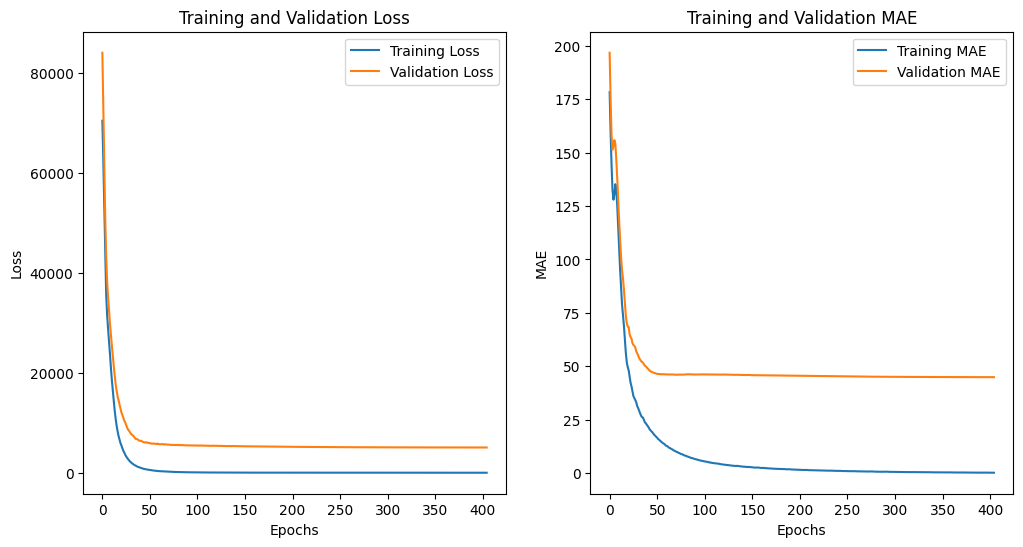

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation MAE
plt.subplot(1, 2, 2)
plt.plot(train_maes, label='Training MAE')
plt.plot(val_maes, label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()


In [ ]:

vgg16.eval()

# Initialize metrics
test_loss = 0.0
test_mae = 0.0

# No gradient updates needed
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        targets = targets.float().unsqueeze(1)

        # Forward pass
        outputs = vgg16(inputs)
        loss = loss_function(outputs, targets)

        # Update metrics
        test_loss += loss.item() * inputs.size(0)
        test_mae += mae(outputs, targets).item() * inputs.size(0)

# Calculate average loss and MAE
test_loss /= len(test_loader.dataset)
test_mae /= len(test_loader.dataset)

print(f'Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}')


Test Loss: 5047.0401, Test MAE: 42.6698


In [ ]:
def calculate_acp(model, test_loader, device, threshold=0.05):
    model.eval()
    acp_counter = 0
    total_images = 0

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            targets = targets.float().unsqueeze(1)
            outputs = model(inputs)
            absolute_diff = torch.abs(outputs - targets)
            within_threshold = absolute_diff <= (threshold * targets)

            acp_counter += torch.sum(within_threshold).item()
            total_images += targets.size(0)


    acp = acp_counter / total_images
    return acp

# Calculate ACP
acp = calculate_acp(vgg16, test_loader, device)
print(f"Accuracy within 5%: {acp * 100}%")



Accuracy within 5%: 21.052631578947366%
